In [ ]:
from pathlib import Path
import sys

# --- Use cwd when __file__ isn't available (Jupyter/IPython) ---
this_dir = Path().resolve()        # current working directory
parent_dir = this_dir.parent
sys.path.insert(0, str(parent_dir))

# ✅ Now this works
from utils_agroforestry import *


# Species Observation Points — Data Retrieval

## Overview
The goal of this notebook is to **collect georeferenced observation points** for a set of target species relevant to our agroforestry crop systems.  
The notebook will pull together observations from multiple data sources to build a consolidated dataset of known species occurrences.

## Purpose
These observation points will be used to:
- Map the known distribution of main crops and associated companion/shade species.
- Support later steps in modelling agroforestry systems across different regions.
- Provide input data for climate suitability and biodiversity overlap analyses.

## Target Species
The species list includes:
- **Main crops**: Coffee (*Coffea arabica*), Cacao (*Theobroma cacao*), Banana (*Musa paradisiaca*).
- **Associated species**: Companion trees, fruit trees, timber species, nitrogen-fixers, and other shade-providing plants used in agroforestry systems.
- Species lists vary by **region** (e.g., Dominican Republic, Guatemala, Mexico) to reflect local agroforestry practices.

## Data Sources
We currently use three main resources:

### 1. GBIF (Global Biodiversity Information Facility)
- Public biodiversity data portal providing occurrence records for millions of species.
- Queried programmatically for each scientific name in our target species list.
- Useful for broad coverage but requires cleaning due to duplicates and variable quality.

### 2. Occurrence data from de Sousa et al. (2019)
In this step, we load the occurrence records provided in **de Sousa et al. (2019)**:  
> de Sousa, K., van Zonneveld, M., Holmgren, M., et al. *The future of coffee and cocoa agroforestry in a warmer Mesoamerica*. **Sci Rep** 9, 8828 (2019). [https://doi.org/10.1038/s41598-019-45491-7](https://doi.org/10.1038/s41598-019-45491-7)

The authors compiled a large dataset of occurrence points for:
- **Coffee** (*Coffea arabica*), which has the highest number of records.
- Various **agroforestry tree and crop species** commonly found in coffee-based systems.

### 3. Coffee data provided by the Alliance of Bioversity International and CIAT (CGIAR)
- Contains curated occurrence data for *Coffea arabica* and other coffee species.
- Provided directly by the Alliance of Bioversity International and CIAT (part of CGIAR).
- Offers more targeted and validated records compared to GBIF.

## Workflow
1. **Define species list**  
   The notebook uses a pre-defined dictionary mapping each target region to its relevant crops and associated species.

2. **Fetch and load occurrence data**  
   - Query GBIF for each target species.
   - Load and merge occurrence datasets from de Sousa et al. (2019) and CGIAR.

3. **Clean and consolidate**  
   - Remove duplicates and invalid coordinates.
   - Optionally filter by observation date or coordinate uncertainty.
   - Add columns on forest coverage and canopy height at coffee and cacao points

4. **Export**  
   - Save the cleaned dataset as CSV/GeoJSON for later use in spatial analyses.

## Notes
- Observation counts and data quality vary greatly between species and regions.
- GBIF data is typically the starting point, but merging with de Sousa et al. (2019) and CGIAR improves coverage and reliability.
- Coordinate cleaning is essential before using these points for modelling or mapping.


### The TARGET_SPECIES are the typical systems defined in the notebook called "Build_typical_plot"

In [1]:
TARGET_SPECIES = {
    "DR": {
        "Coffee": [
            {"Species": "Coffee", "Scientific name": "Coffea arabica"},
            {"Species": "Guama", "Scientific name": "Inga vera"},
            {"Species": "Bitter orange", "Scientific name": "Citrus aurantium"},
            {"Species": "Sweet orange", "Scientific name": "Citrus sinensis"},
            {"Species": "Sapote", "Scientific name": "Pouteria sapota"},
            {"Species": "Breadfruit", "Scientific name": "Artocarpus altilis"},
            {"Species": "Avocado", "Scientific name": "Persea americana"},
        ],
        "Cacao": [
            {"Species": "Cacao", "Scientific name": "Theobroma cacao"},
            {"Species": "Gliricidia (Piñón cubano)", "Scientific name": "Gliricidia sepium"},
            {"Species": "Guama", "Scientific name": "Inga vera"},
            {"Species": "Bitter orange", "Scientific name": "Citrus aurantium"},
            {"Species": "Sweet orange", "Scientific name": "Citrus sinensis"},
            {"Species": "Sapote", "Scientific name": "Pouteria sapota"},
            {"Species": "Breadfruit", "Scientific name": "Artocarpus altilis"},
            {"Species": "Avocado", "Scientific name": "Persea americana"},
        ],
        "Banana": [
            {"Species": "Banana", "Scientific name": "Musa x paradisiaca"}
        ]
    },
    "GTM": {
        "Coffee": [
            {"Species": "Coffee", "Scientific name": "Coffea arabica"},
            {"Species": "Guama", "Scientific name": "Inga edulis"},
            {"Species": "Cedar", "Scientific name": "Cedrela odorata"},
            {"Species": "Oak", "Scientific name": "Quercus spp."},
            {"Species": "Walnut", "Scientific name": "Juglans spp."},
            {"Species": "Banana", "Scientific name": "Musa paradisiaca"},
            {"Species": "Avocado", "Scientific name": "Persea americana"},
            {"Species": "Citrus", "Scientific name": "Citrus sinensis"},
            {"Species": "Pacaya", "Scientific name": "Chamaedorea spp."},
            {"Species": "Hog plum", "Scientific name": "Spondias mombin"},
        ],
        "Cacao": [
            {"Species": "Cacao", "Scientific name": "Theobroma cacao"},
            {"Species": "Guama", "Scientific name": "Inga edulis"},
            {"Species": "Gliricidia", "Scientific name": "Gliricidia sepium"},
            {"Species": "Avocado", "Scientific name": "Persea americana"},
            {"Species": "Banana", "Scientific name": "Musa paradisiaca"},
            {"Species": "Citrus", "Scientific name": "Citrus sinensis"},
            {"Species": "Erythrina", "Scientific name": "Erythrina poeppigiana"},
            {"Species": "Pigeon pea", "Scientific name": "Cajanus cajan"},
        ]
    },
    "MEX": {
        "Coffee": [
            {"Species": "Coffee", "Scientific name": "Coffea arabica"},
            {"Species": "Guava", "Scientific name": "Psidium guajava"},
            {"Species": "Guama", "Scientific name": "Inga jinicuil"},
            {"Species": "Avocado", "Scientific name": "Persea americana"},
            {"Species": "Banana", "Scientific name": "Musa paradisiaca"},
            {"Species": "Mango", "Scientific name": "Mangifera indica"},
            {"Species": "Citrus", "Scientific name": "Citrus sinensis"},
            {"Species": "Soursop", "Scientific name": "Annona muricata"},
            {"Species": "Nance", "Scientific name": "Byrsonima crassifolia"},
            {"Species": "Sapote", "Scientific name": "Pouteria sapota"},
            {"Species": "Macadamia", "Scientific name": "Macadamia integrifolia"},
            {"Species": "Papaya", "Scientific name": "Carica papaya"},
            {"Species": "Cedar", "Scientific name": "Cedrela odorata"},
            {"Species": "Mahogany", "Scientific name": "Swietenia macrophylla"},
            {"Species": "Laurel", "Scientific name": "Cordia alliodora"},
            {"Species": "Cuajinicuil", "Scientific name": "Inga jinicuil"},
        ]
    }
}


In [2]:
from utils_agroforestry import *

In [3]:
# 📋 Build list of target species from TARGET_SPECIES dict
target_species = sorted({
    clean_species_name(sp["Scientific name"])
    for region_data in TARGET_SPECIES.values()
    for species_list in region_data.values()
    for sp in species_list
})


In [4]:
target_species

['Annona muricata',
 'Artocarpus altilis',
 'Byrsonima crassifolia',
 'Cajanus cajan',
 'Carica papaya',
 'Cedrela odorata',
 'Chamaedorea spp.',
 'Citrus aurantium',
 'Citrus sinensis',
 'Coffea arabica',
 'Cordia alliodora',
 'Erythrina poeppigiana',
 'Gliricidia sepium',
 'Inga edulis',
 'Inga jinicuil',
 'Inga vera',
 'Juglans spp.',
 'Macadamia integrifolia',
 'Mangifera indica',
 'Musa paradisiaca',
 'Musa x',
 'Persea americana',
 'Pouteria sapota',
 'Psidium guajava',
 'Quercus spp.',
 'Spondias mombin',
 'Swietenia macrophylla',
 'Theobroma cacao']

### locations from De Sousa et al.

In [5]:
import pandas as pd
from config import DATA_DIR

# 📄 Path to your Excel file (in UNU/data)
excel_path = DATA_DIR / "species_location/occurrence_data.xlsx"

# 🧹 Load and clean the 'Data' sheet
de_sousa = pd.read_excel(excel_path, sheet_name="Data").rename(columns={
    "lon": "decimalLongitude",
    "lat": "decimalLatitude"
})
de_sousa["species"] = de_sousa["species"].apply(clean_species_name)

# ✅ Filter to target species
de_sousa = de_sousa[de_sousa["species"].isin(target_species)]

# 🔍 Summary
print(f"✅ Excel: {len(de_sousa)} records for target species.")
de_sousa.head()


✅ Excel: 28894 records for target species.


,acronym,family,species,decimalLongitude,decimalLatitude,source,url,main_use,neotropical
5518,ANNOMU,Annonaceae,Annona muricata,-93.362194,17.979742,GBIF,https://www.gbif.org/occurrence/search?q=,Fruit,Yes
5519,ANNOMU,Annonaceae,Annona muricata,-92.045242,17.484511,GBIF,https://www.gbif.org/occurrence/search?q=,Fruit,Yes
5520,ANNOMU,Annonaceae,Annona muricata,-87.340118,21.425954,GBIF,https://www.gbif.org/occurrence/search?q=,Fruit,Yes
5521,ANNOMU,Annonaceae,Annona muricata,-92.511574,14.939840,GBIF,https://www.gbif.org/occurrence/search?q=,Fruit,Yes
5522,ANNOMU,Annonaceae,Annona muricata,-96.425490,15.914490,GBIF,https://www.gbif.org/occurrence/search?q=,Fruit,Yes


### locations from GBIF:

In [6]:
# 1️⃣ Get GBIF data
from shapely.geometry import box
import time


cutoff_year = 1990
min_points_per_species = 100
bbox = (-115, 10, -50, 25)  # (lon_min, lat_min, lon_max, lat_max)
wkt_bbox = box(*bbox).wkt

df_gbif_recent = get_gbif_occurrences_for_species(
    species_list=target_species,
    wkt_bbox=wkt_bbox,
    year_min=cutoff_year
)

print(f"📊 GBIF records after {cutoff_year}: {len(df_gbif_recent)}")

# 2️⃣ Deduplicate
df_gbif_recent = df_gbif_recent.drop_duplicates(
    subset=["species_query", "decimalLongitude", "decimalLatitude"]
)

# 3️⃣ Summary
final_counts = df_gbif_recent.groupby("species_query").size().reset_index(name="final_count")
print(f"✅ Final dataset after deduplication: {len(df_gbif_recent)} records")
print(final_counts.sort_values("final_count", ascending=False))


🌱 Fetching GBIF: Annona muricata
  📦 300 total | 300 kept ≥1990 for Annona muricata
  📦 600 total | 600 kept ≥1990 for Annona muricata
  📦 900 total | 900 kept ≥1990 for Annona muricata
  📦 1200 total | 983 kept ≥1990 for Annona muricata
  📦 1500 total | 983 kept ≥1990 for Annona muricata
🌱 Fetching GBIF: Artocarpus altilis
  📦 300 total | 300 kept ≥1990 for Artocarpus altilis
  📦 600 total | 600 kept ≥1990 for Artocarpus altilis
  📦 900 total | 900 kept ≥1990 for Artocarpus altilis
  📦 1200 total | 1200 kept ≥1990 for Artocarpus altilis
  📦 1500 total | 1500 kept ≥1990 for Artocarpus altilis
  📦 1800 total | 1800 kept ≥1990 for Artocarpus altilis
  📦 2100 total | 1897 kept ≥1990 for Artocarpus altilis
🌱 Fetching GBIF: Byrsonima crassifolia
  📦 300 total | 300 kept ≥1990 for Byrsonima crassifolia
  📦 600 total | 600 kept ≥1990 for Byrsonima crassifolia
  📦 900 total | 900 kept ≥1990 for Byrsonima crassifolia
  📦 1200 total | 1200 kept ≥1990 for Byrsonima crassifolia
  📦 1500 total | 15

## Coffee locations from CIAT:

In [7]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from config import DATA_DIR

# Load CSV
df_coffee_ciat = pd.read_csv(DATA_DIR / "species_location/CoffeeCAM_anonymized.csv")



### let's merge everything and clean: 

In [12]:
import numpy as np

# --- 1) GBIF recent ---
df_gb = df_gbif_recent.copy()
df_gb["source"] = df_gb.get("source", "GBIF")
if "year" not in df_gb.columns:
    df_gb["year"] = np.nan

# --- 2) De Sousa / Excel ---
df_ds = de_sousa.copy()
df_ds["source"] = df_ds.get("source", "De Sousa")
if "year" not in df_ds.columns:
    df_ds["year"] = np.nan
# ensure column naming consistency
df_ds = df_ds.rename(columns={"species": "species_query"})

# --- 3) CoffeeCAM CSV ---
df_cof = df_coffee_ciat.rename(columns={
    "Longitude": "decimalLongitude",
    "Latitude": "decimalLatitude"
})
df_cof = df_cof.assign(
    species_query=clean_species_name("Coffea arabica"),
    year=np.nan,
    source="CoffeeCAM"
)

# --- unify all columns ---
common_cols = ["species_query", "decimalLongitude", "decimalLatitude", "year", "source"]
all_parts = [
    df_gb[common_cols],
    df_ds[common_cols],
    df_cof[common_cols]
]

df_all = pd.concat(all_parts, ignore_index=True)

# --- coordinate cleaning ---
df_all = df_all.dropna(subset=["decimalLongitude", "decimalLatitude"])
df_all = df_all[
    df_all["decimalLongitude"].between(bbox[0], bbox[2]) &
    df_all["decimalLatitude"].between(bbox[1], bbox[3])
]
# remove (0,0) points
df_all = df_all[~((df_all["decimalLongitude"].abs() < 1e-9) &
                  (df_all["decimalLatitude"].abs() < 1e-9))]

# --- deduplicate ---
df_all = df_all.drop_duplicates(subset=["species_query", "decimalLongitude", "decimalLatitude"]).reset_index(drop=True)

# --- summary ---
print(f"✅ Final merged dataset: {len(df_all)} records")
print(df_all.groupby("source").size().sort_values(ascending=False))
print("\nTop species:")
print(df_all.groupby("species_query").size().sort_values(ascending=False).head(10))

df_all.head()


✅ Final merged dataset: 41414 records
source
GBIF                               37550
CoffeeCAM                           2722
CATIE Inventories                    813
Boshier and Lamb (1997)              135
Personal Inventories                  56
Museo Nacional de Costa Rica          23
DiscoverLife                          19
SpLink                                10
Somarriba et al (2013)                 9
Tropicos                               9
SINCHI                                 8
CONABIO-Naturalista                    8
Neotropical Herbarium Specimens        3
Chamberlain et al. (1995)              3
SIB Portal de Datos                    1
Herbarium WU                           1
dtype: int64

Top species:
species_query
Gliricidia sepium        4423
Coffea arabica           3975
Psidium guajava          3758
Carica papaya            3420
Byrsonima crassifolia    3156
Inga vera                2848
Mangifera indica         2768
Persea americana         2247
Inga edulis       

,species_query,decimalLongitude,decimalLatitude,year,source
0,Annona muricata,-73.787033,11.239887,2025.0,GBIF
1,Annona muricata,-84.167708,10.040435,2025.0,GBIF
2,Annona muricata,-85.033944,10.885278,2025.0,GBIF
3,Annona muricata,-61.129347,14.679253,2025.0,GBIF
4,Annona muricata,-69.201520,19.292958,2025.0,GBIF


In [13]:
import numpy as np
import pandas as pd

# Ensure year is numeric so we can keep the newest
if "year" in df_all.columns:
    df_all["year"] = pd.to_numeric(df_all["year"], errors="coerce").astype("Int64")
else:
    df_all["year"] = np.nan

# 1) Drop exact coordinate duplicates per species
df_all = df_all.drop_duplicates(subset=["species_query", "decimalLongitude", "decimalLatitude"])

# 2) Drop near-duplicates within ~1 km using a 0.01° grid (~1.1 km N–S; ~1.1 km * cos(lat) E–W)
#    Sort so the newest year is kept when collapsing cells.
df_all = df_all.sort_values(["species_query", "year"], ascending=[True, False]).copy()
cell_deg = 0.01  # ≈1.1 km; set to 0.009 for ~1.0 km

df_all["_lon_cell"] = (df_all["decimalLongitude"] / cell_deg).round().astype("Int64")
df_all["_lat_cell"]  = (df_all["decimalLatitude"]  / cell_deg).round().astype("Int64")

df_all = (
    df_all
    .drop_duplicates(subset=["species_query", "_lon_cell", "_lat_cell"])
    .drop(columns=["_lon_cell", "_lat_cell"])
    .reset_index(drop=True)
)

print(f"✅ Cleaned: {len(df_all)} records after exact + ~1 km de-dup")
print(df_all.groupby("species_query").size().sort_values(ascending=False).head(10))


✅ Cleaned: 30307 records after exact + ~1 km de-dup
species_query
Coffea arabica           3561
Psidium guajava          3034
Carica papaya            2610
Byrsonima crassifolia    2330
Mangifera indica         2018
Inga vera                1989
Gliricidia sepium        1914
Persea americana         1878
Inga edulis              1570
Cedrela odorata          1408
dtype: int64


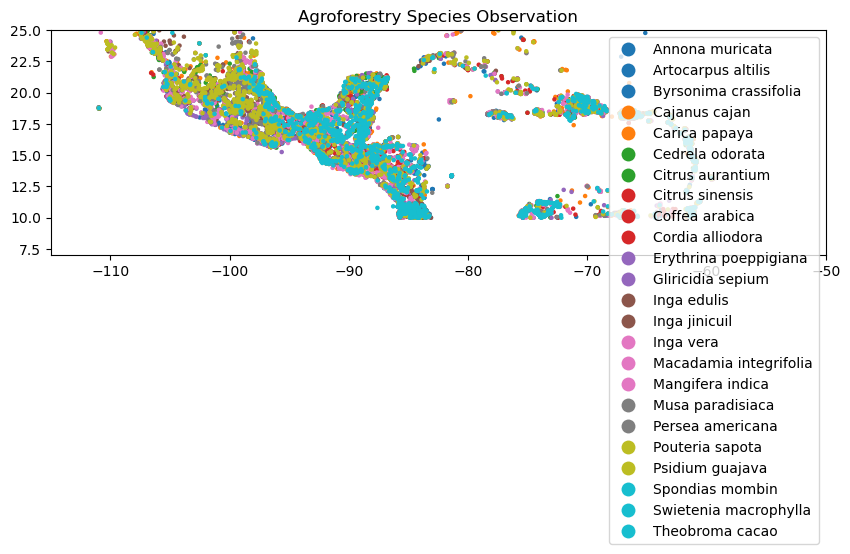

In [14]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Quick map of points, coloured by source
gdf = gpd.GeoDataFrame(
    df_all,
    geometry=gpd.points_from_xy(df_all["decimalLongitude"], df_all["decimalLatitude"]),
    crs="EPSG:4326"
)

fig, ax = plt.subplots(figsize=(10, 6))
gdf.plot(ax=ax, column="species_query", categorical=True, legend=True, markersize=5)
ax.set_xlim(-115, -50)
ax.set_ylim(7, 25)
ax.set_title("Agroforestry Species Observation")
plt.show()


In [16]:
# 📄 Save combined cleaned dataset
output_path = DATA_DIR / "species_location/species_occurrences_combined_cleaned.csv"
df_all.to_csv(output_path, index=False)

print(f"✅ Saved combined dataset to: {output_path}")
print(f"📊 Final number of records: {len(df_all)}")


✅ Saved combined dataset to: /Users/szelie/data/biofincas/species_location/species_occurrences_combined_cleaned.csv
📊 Final number of records: 30307


# We know add some different info that we have from sattelite products


## 1. Canopy Height
- **Dataset:** Global Canopy Height 2020 (10 m)  
- **Source:** ETH Zürich — Lang, N., et al. (2023)  
- **Description:**  
  Global canopy height map for 2020 at 10 m resolution, derived from Sentinel-1, Sentinel-2, and ICESat-2 data. Used to estimate the average canopy height within plot boundaries.  
- **Files used:** `ETH_GlobalCanopyHeight_10m_2020_*.tif` (Dominican Republic tiles)  
- **DOI:** [https://doi.org/10.1038/s41597-023-01938-2](https://doi.org/10.1038/s41597-023-01938-2)  
- **CRS:** EPSG:4326

---

## 2. Forest Cover
- **Dataset:** Hansen Global Forest Change v1.10 — Tree Cover 2000 (%)  
- **Source:** Hansen, M.C., et al. (2013, updated annually), University of Maryland  
- **Description:**  
  Percent tree canopy cover per pixel for the year 2000, at ~30 m resolution, derived from Landsat imagery. Used as a baseline estimate of forest cover within each plot area.  
  *Note:* This static 2000 baseline does not account for forest loss or gain after 2000. Loss/gain data from the same product can be used for updates if needed.  
- **Download:** [https://earthenginepartners.appspot.com/science-2013-global-forest](https://earthenginepartners.appspot.com/science-2013-global-forest)  
- **CRS:** EPSG:4326

---
## 3. We could also add Land Use / Land Cover (we did not do it here)
- **Dataset:** ESA WorldCover 10 m 2021 v200  
- **Source:** European Space Agency (ESA), Climate Change Initiative (CCI)  
- **Description:**  
  Global land cover classification at 10 m resolution for 2021. Used to identify broad land cover categories (e.g., cropland, forest, shrubland) within the plot areas.  

- **URL:** [https://worldcover2021.esa.int](https://worldcover2021.esa.int)  
- **CRS:** EPSG:4326

---


## Processing
For each plot centroid, a square area corresponding to the estimated plot size was defined. Mean values for:
- **Forest cover (%)**
- **Canopy height (m)**
- **Land use class**  
were extracted from the relevant raster tiles using zonal averaging.

In [17]:
import pandas as pd
from config import DATA_DIR

# Load and ensure numeric coords
df_all = pd.read_csv(DATA_DIR / "species_location/species_occurrences_combined_cleaned.csv")
df_all["decimalLongitude"] = pd.to_numeric(df_all["decimalLongitude"], errors="coerce")
df_all["decimalLatitude"] = pd.to_numeric(df_all["decimalLatitude"], errors="coerce")

# Drop rows with NaNs in coords
df_all = df_all.dropna(subset=["decimalLongitude", "decimalLatitude"])

# Bounding box
min_lon, min_lat, max_lon, max_lat = -115, 10, -50, 25

# Filter
df_box = df_all[
    (df_all["decimalLongitude"] >= min_lon) &
    (df_all["decimalLongitude"] <= max_lon) &
    (df_all["decimalLatitude"]  >= min_lat) &
    (df_all["decimalLatitude"]  <= max_lat)
]

print(f"Original: {len(df_all)}, After filter: {len(df_box)}")
df_box.head()


Original: 30307, After filter: 30307


,species_query,decimalLongitude,decimalLatitude,year,source
0,Annona muricata,-73.787033,11.239887,2025.0,GBIF
1,Annona muricata,-84.167708,10.040435,2025.0,GBIF
2,Annona muricata,-85.033944,10.885278,2025.0,GBIF
3,Annona muricata,-61.129347,14.679253,2025.0,GBIF
4,Annona muricata,-69.201520,19.292958,2025.0,GBIF


In [18]:
# Convert df_all to GeoDataFrame
from shapely.geometry import Point
import geopandas as gpd
from utils_agroforestry import validate_paths, extract_mean_raster_value_by_area, apply_satellite_features_to_geodf, classify_agroforestry
gdf = gpd.GeoDataFrame(
    df_box,
    geometry=[Point(xy) for xy in zip(df_box.decimalLongitude, df_box.decimalLatitude)],
    crs="EPSG:4326"
)

# Ensure gdf is a GeoDataFrame
if not isinstance(gdf, gpd.GeoDataFrame):
    gdf = gpd.GeoDataFrame(gdf, geometry=gdf['geometry'], crs="EPSG:4326")

# Filter for coffee or cacao
target_species = ["Coffea arabica", "Theobroma cacao"]
gdf_selected = gdf[gdf['species_query'].isin(target_species)].copy()

# Apply satellite features
gdf_selected = apply_satellite_features_to_geodf(gdf_selected)


In [19]:
# 📄 Save combined cleaned dataset
output_path = DATA_DIR / "species_location/coffee_cacao_occurrences_combined_cleaned.csv"
gdf_selected.to_csv(output_path, index=False)

print(f"✅ Saved combined dataset to: {output_path}")
print(f"📊 Final number of records: {len(gdf_selected)}")


NameError: name 'gdf_selected' is not defined

In [ ]:
gdf_selected

In [ ]:
import geopandas as gpd
import folium
import branca.colormap as cm
import numpy as np

gdf_latlon = gdf_selected.copy()

center = [
    gdf_latlon.geometry.y.mean(),
    gdf_latlon.geometry.x.mean()
]
m = folium.Map(location=center, zoom_start=12, tiles=None)

folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri World Imagery",
    name="Esri Satellite",
    overlay=False,
    control=True
).add_to(m)

min_height = gdf_latlon['canopy_height'].min()
max_height = gdf_latlon['canopy_height'].max()

colormap = cm.LinearColormap(
    colors=["#ffffcc", "#006837"],  # light yellow → dark green
    vmin=min_height,
    vmax=max_height
)
colormap.caption = 'Canopy Height (m)'
colormap.add_to(m)

for _, row in gdf_latlon.iterrows():
    height = row.get('canopy_height', None)
    if height is not None and not np.isnan(height):
        colour = colormap(height)
    else:
        colour = "grey"
        
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=6,
        color=colour,
        fill=True,
        fill_opacity=0.8,
        popup=folium.Popup(f"""
            <b>Canopy height:</b> {height} m<br>
            <b>Forest cover:</b> {row.get('forest_cover', 'n/a')} %<br>
            <b>Land use:</b> {row.get('land_use_class', 'n/a')}<br>
        """, max_width=250)
    ).add_to(m)

folium.LayerControl().add_to(m)
m
